In [2]:
import random
import pandas as pd
import numpy as np
from collections import namedtuple
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.dates import DAILY, DateFormatter, rrulewrapper, RRuleLocator, datestr2num

import pdb

### Define needed data structure

In [3]:
Measure = namedtuple('Measure', 'C1 C2, C3, C4, C5, C6, C7, C8, H1, stringency')
Tested = namedtuple('Tested', 'cumulative daily')
Confirmed = namedtuple('Confirmed', 'cumulative daily')
Combined = namedtuple('Combined', 'measure confirmed tested')

### Load the cleaned and integrated data

In [4]:
import pickle

filename = '../cleaned_integrated_data.pkl'

with open(filename, 'rb') as fp:
    loaded = pickle.load(fp)
    
print('Total number of samples: {}'.format(len(loaded)))

key = random.choice(list(loaded.keys()))
print('A random sample in the integrated dataset:')
print('key: ', key)
print('value: ', loaded[key])

Total number of samples: 3470
A random sample in the integrated dataset:
key:  (Timestamp('2020-04-28 00:00:00'), 'Nigeria')
value:  Combined(measure=Measure(C1=3.0, C2=2.0, C3=2.0, C4=3.0, C5=2.0, C6=2.0, C7=2.0, C8=4.0, H1=2.0, stringency=89.55), confirmed=Confirmed(cumulative=1532, daily=195), tested=Tested(cumulative=12004, daily=None))


In [5]:
a2m = {'C1': 'C1_School closing', 'C2': 'C2_Workplace closing', 'C3': 'C3_Cancel public events', 'C4': 'C4_Restrictions on gatherings', 
       'C5': 'C5_Close public transport', 'C6': 'C6_Stay at home requirements', 'C7': 'C7_Restrictions on internal movement', 
       'C8': 'C8_International travel controls', 'H1': 'H1_Public information campaigns'}
m2a = {v: k for k, v in a2m.items()}

### Helper functions

In [6]:
from collections import OrderedDict

def search_by_country(country, dataset):
    res_by_country = dict()
    for key, value in dataset.items():
        if country in key:
            res_by_country[key] = value

    return res_by_country

def search_by_date(date, dataset):
    res_by_date = dict()
    for key, value in dataset.items():
        if date in key:
            res_by_date[key] = value

    return res_by_date

def sort_by_date(samples):
    sorted_samples = OrderedDict(sorted(samples.items(), key=lambda t: t[0][0]))

    return sorted_samples

### Visualize government measurement over time

In [7]:
import io
import requests

# Oxford Covid-19 Government Response Tracker (OxCGRT)
oxcgrt_url = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
oxcgrt_data = requests.get(oxcgrt_url).content
oxcgrt_data = pd.read_csv(io.StringIO(oxcgrt_data.decode('utf-8')))

In [8]:
# select C1 to C8, H1 and Stringency Index
dc_measure_data = dict()
Measure = namedtuple('Measure', 'C1 C2, C3, C4, C5, C6, C7, C8, H1, stringency')
for index, row in oxcgrt_data.iterrows():
    value = []
    for abbr, measure in a2m.items():
        if np.isnan(row[measure]):
            value.append(None)
        else:
            value.append(row[measure])
    if np.isnan(row['StringencyIndexForDisplay']):
        value.append(None)
    else:
        value.append(row['StringencyIndexForDisplay'])

    key = (row['Date'], row['CountryName'])
    value = Measure(*value)
    dc_measure_data[key] = value

In [9]:
# statistics of some countries are not available
def check_name(name, name_list):
    names = name.split(' ')
    if len(names) == 1:
        if names[0] in name_list:
            return True, names[0]
    if len(names) == 2:
        if ' '.join(names) in name_list:
            return True, ' '.join(names)
    if len(names) >= 3:
        if ' '.join(names[0:2]) in name_list:
            return True, ' '.join(names[0:2])
        
    return False, None

In [10]:
def vis_gov_meas(date):
    res_by_date = search_by_date(int(date), dc_measure_data)

    # extract stringency and country to form a compact dataset
    country2stringency = dict()
    for key, value in res_by_date.items():
        if isinstance(value.stringency, float) or isinstance(value.stringency, int):
            country2stringency[key[1]] = value.stringency

    # load world map
    shapename = 'admin_0_countries'
    countries_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

    # convert from stringency to color, higher the stringency index, deeper the color
    cmap = cm.Greens
    norm = mpl.colors.Normalize(vmin=0, vmax=100)
    for key, value in country2stringency.items():
        country2stringency[key] = cmap(norm(value))[0:3]

    # set figure size
    plt.figure(figsize=(12, 16))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    name_list = list(country2stringency.keys())

    for country in shpreader.Reader(countries_shp).records():
        country_name = country.attributes['NAME']
        exist_flag, country_name = check_name(country_name, name_list)
        # country data found
        if exist_flag:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(), 
                              facecolor=country2stringency[country_name],
                              label=country.attributes['NAME'])
        # no data for this country
        else:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(), 
                              facecolor=(1.0, 1.0, 1.0),
                              label=country.attributes['NAME'])

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    plt.colorbar(sm, fraction=0.0239, pad=0.02)
    
    plt.title(date[0:4] + '-' + date[4:6] + '-' + date[6:])
    
    plt.show()

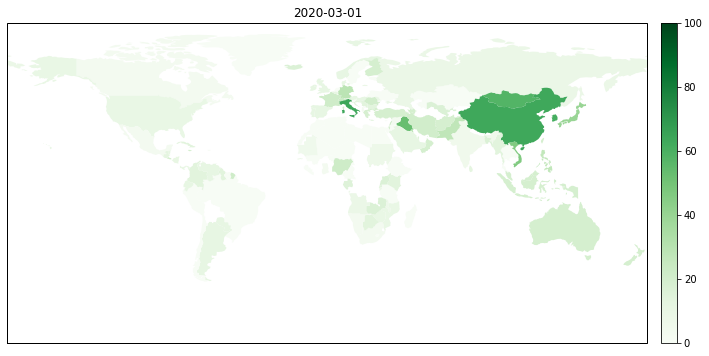

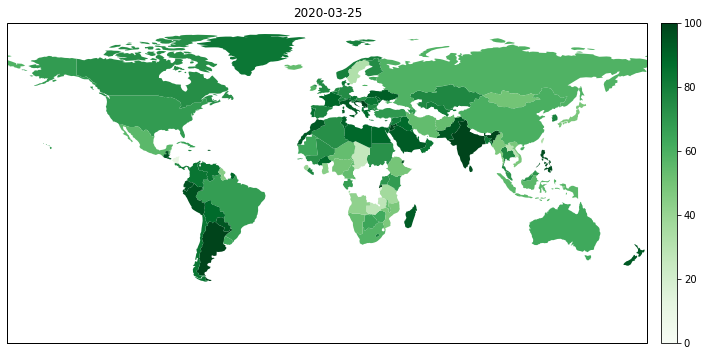

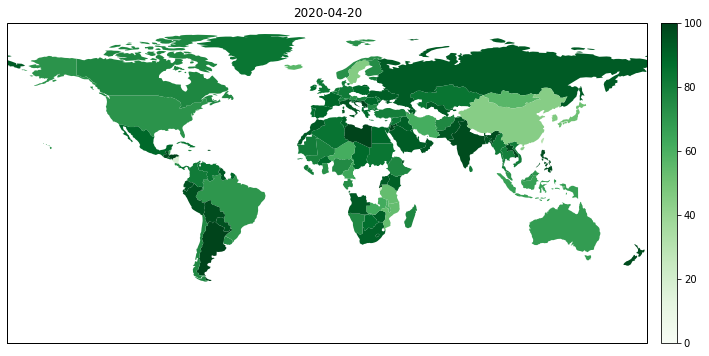

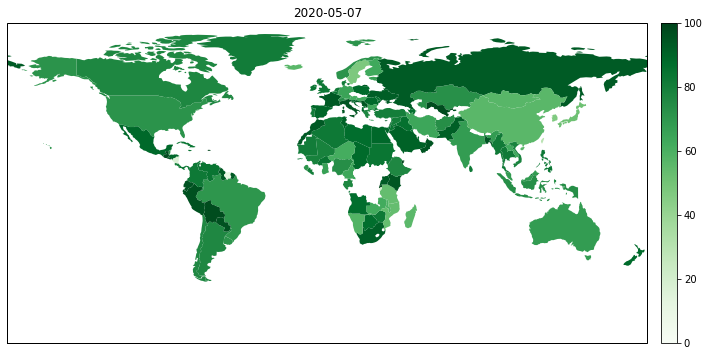

In [11]:
# ref: https://stackoverflow.com/questions/13397022/fill-countries-in-python-basemap
import itertools
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

date = '20200301'
vis_gov_meas(date)

date = '20200325'
vis_gov_meas(date)

date = '20200420'
vis_gov_meas(date)

date = '20200507'
vis_gov_meas(date)

#### Visualize confirmed cases over time

In [29]:
confirmed_url = 'https://datahub.io/core/covid-19/r/time-series-19-covid-combined.csv'
confirmed_data = requests.get(confirmed_url).content
confirmed_data = pd.read_csv(io.StringIO(confirmed_data.decode('utf-8')))

In [30]:
confirmed_data = confirmed_data.replace('US', 'United States')

dc_confirmed_dict = dict()  # 'dc' means date and country
for index, row in confirmed_data.iterrows():
    key = (row['Date'], row['Country/Region'])
    if not np.isnan(row['Confirmed']):
        if key in dc_confirmed_dict.keys():
            dc_confirmed_dict[key] = dc_confirmed_dict[key] + int(row['Confirmed'])
        else:
            dc_confirmed_dict[key] = int(row['Confirmed'])

In [31]:
import math

def vis_confirmed(date):
    res_by_date = search_by_date(date, dc_confirmed_dict)

    # extract confirmed cases and country to form a compact dataset
    country2confirmed = dict()
    for key, value in res_by_date.items():
        if isinstance(value, float) or isinstance(value, int):
            country2confirmed[key[1]] = value

    # load world map
    shapename = 'admin_0_countries'
    countries_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

    # convert from stringency to color, higher the stringency index, deeper the color
    cmap = cm.Blues
    norm = mpl.colors.Normalize(vmin=0, vmax=math.log(1000000))
    for key, value in country2confirmed.items():
        country2confirmed[key] = cmap(norm(math.log(value + 1e-6)))[0:3]

    # set figure size
    plt.figure(figsize=(12, 16))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    name_list = list(country2confirmed.keys())

    for country in shpreader.Reader(countries_shp).records():
        country_name = country.attributes['NAME']
        exist_flag, country_name = check_name(country_name, name_list)
        # country data found
        if exist_flag:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(), 
                              facecolor=country2confirmed[country_name],
                              label=country.attributes['NAME'])
        # no data for this country
        else:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(), 
                              facecolor=(1.0, 1.0, 1.0),
                              label=country.attributes['NAME'])

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    plt.colorbar(sm, fraction=0.0239, pad=0.02)
    
    plt.title(date[0:4] + '-' + date[4:6] + '-' + date[6:])
    
    plt.show()

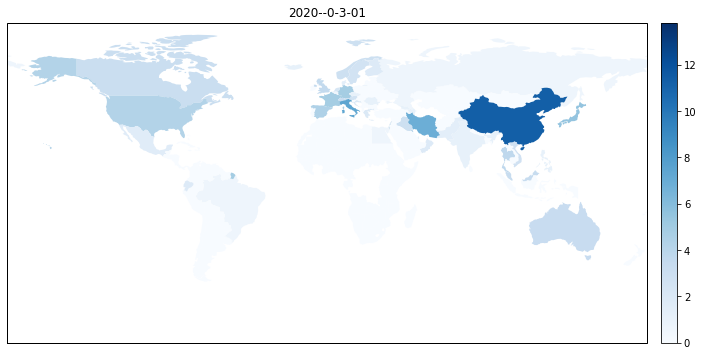

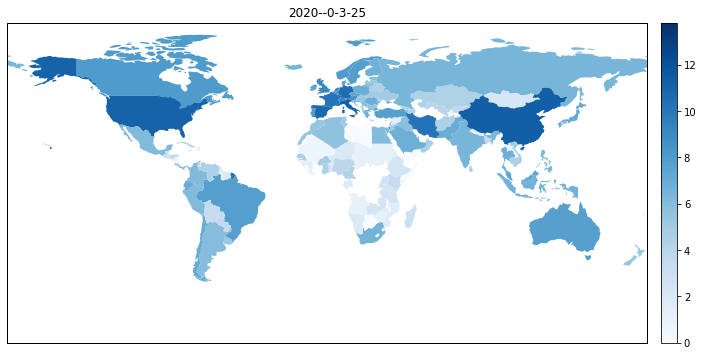

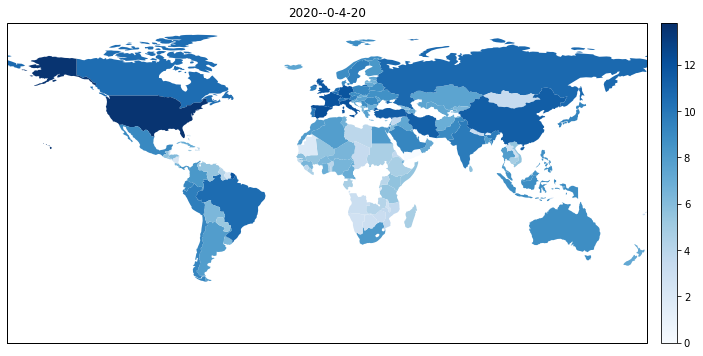

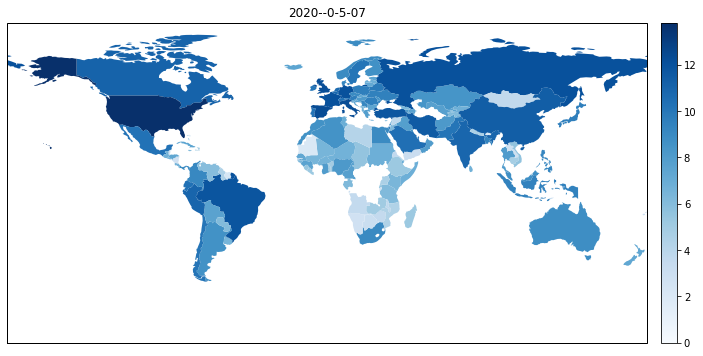

In [32]:
date = '2020-03-01'
vis_confirmed(date)

date = '2020-03-25'
vis_confirmed(date)

date = '2020-04-20'
vis_confirmed(date)

date = '2020-05-07'
vis_confirmed(date)

#### Visualize the relation between a government measurement and the confirmed ratio

In [32]:
def vis_meas_over_ratio(country, measurement):
    res_by_country = search_by_country(country, loaded)
    sorted_samples = sort_by_date(res_by_country)

    dates = [key[0].strftime('%Y-%m-%d') for key in sorted_samples.keys()]
    dates = datestr2num(dates)

    # cumulative confirmed cases and tested cases
    cum_confirmed = [value.confirmed.cumulative for value in sorted_samples.values()]
    cum_tested = [value.tested.cumulative for value in sorted_samples.values()]

    confirmed_over_tested = [c / t for c, t in zip(cum_confirmed, cum_tested)]

    if measurement == 'stringency':
        meas_values = [value.measure.stringency for value in sorted_samples.values()]
    else:
        meas_values = [getattr(value.measure, measurement) for value in sorted_samples.values()]

    rule = rrulewrapper(DAILY, interval=10)
    loc = RRuleLocator(rule)
    formatter = DateFormatter('%Y-%m-%d')
    
    fig, ax1 = plt.subplots()
    ax1.plot_date(dates, confirmed_over_tested, 'r')
    ax1.set_ylabel('ratio', color='red')

    ax2 = ax1.twinx()
    ax2.plot_date(dates, meas_values, 'b')
    if measurement == 'stringency':
        ax2.set_ylabel('stringency', color='blue')
    else:
        ax2.set_ylabel(a2m[measurement], color='blue')

    ax1.xaxis.set_major_locator(loc)
    ax1.xaxis.set_major_formatter(formatter)
    ax1.xaxis.set_tick_params(rotation=30, labelsize=10)

    plt.title(country)

    plt.show()

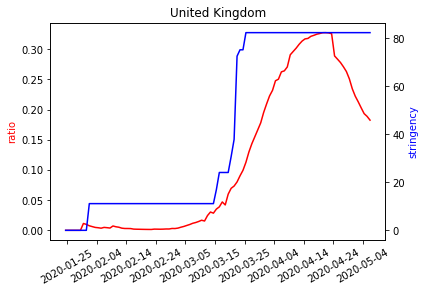

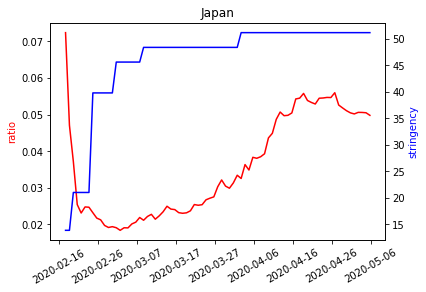

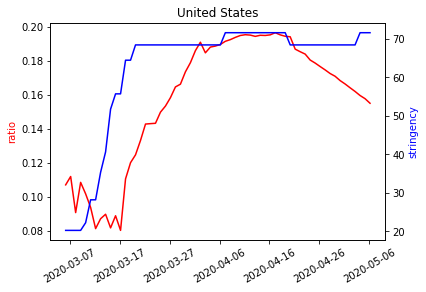

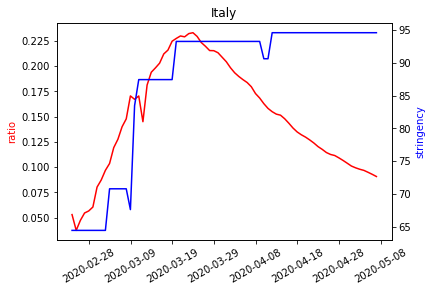

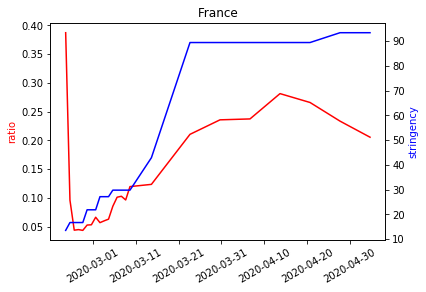

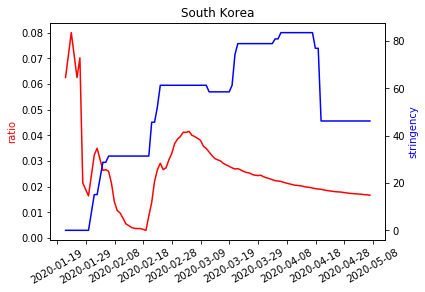

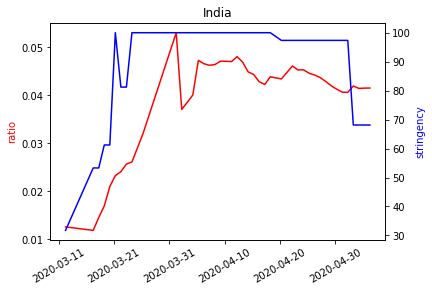

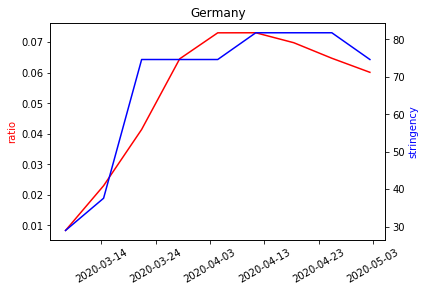

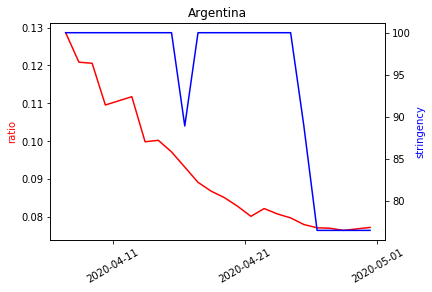

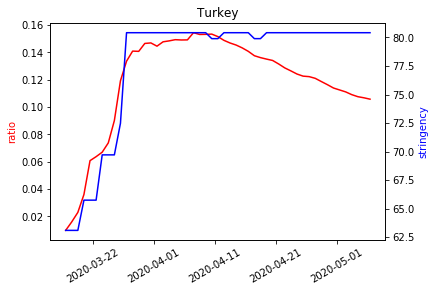

In [33]:
# select a country as an example
# ref: https://matplotlib.org/3.1.1/gallery/ticks_and_spines/date_demo_rrule.html

country = 'United Kingdom'
vis_meas_over_ratio(country, 'stringency')

country = 'Japan'
vis_meas_over_ratio(country, 'stringency')

country = 'United States'
vis_meas_over_ratio(country, 'stringency')

country = 'Italy'
vis_meas_over_ratio(country, 'stringency')

country = 'France'
vis_meas_over_ratio(country, 'stringency')

country = 'South Korea'
vis_meas_over_ratio(country, 'stringency')

country = 'India'
vis_meas_over_ratio(country, 'stringency')

country = 'Germany'
vis_meas_over_ratio(country, 'stringency')

country = 'Argentina'
vis_meas_over_ratio(country, 'stringency')

country = 'Turkey'
vis_meas_over_ratio(country, 'stringency')

#### Auto-regression model for ratio

In [14]:
from pandas.plotting import lag_plot, autocorrelation_plot
import pdb

def auto_correlation_analyze(country):
    res_by_country = search_by_country(country, loaded)
    sorted_samples = sort_by_date(res_by_country)

    dates = [key[0].strftime('%Y-%m-%d') for key in sorted_samples.keys()]

    # cumulative confirmed cases and tested cases
    cum_confirmed = [value.confirmed.cumulative for value in sorted_samples.values()]
    cum_tested = [value.tested.cumulative for value in sorted_samples.values()]

    confirmed_over_tested = [c / t for c, t in zip(cum_confirmed, cum_tested)]
    
    # combine into a DataFrame
    df = pd.DataFrame({'Date': dates, 'Ratio': confirmed_over_tested}).set_index('Date')
    
    values = pd.DataFrame(df.values)
    dataframe = pd.concat([values.shift(1), values], axis=1)
    dataframe.columns = ['t-1', 't+1']
    result = dataframe.corr()
    print(result)
    
#     autocorrelation_plot(df)
#     plt.show()
    
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(df, lags=60)
    
    plt.title(country)
    plt.show()

          t-1       t+1
t-1  1.000000  0.983072
t+1  0.983072  1.000000


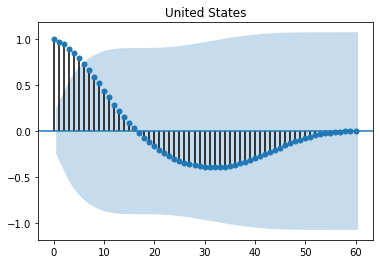

          t-1       t+1
t-1  1.000000  0.964507
t+1  0.964507  1.000000


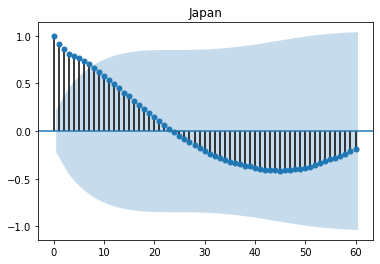

         t-1      t+1
t-1  1.00000  0.98788
t+1  0.98788  1.00000


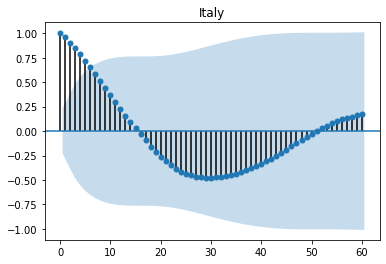

          t-1       t+1
t-1  1.000000  0.886376
t+1  0.886376  1.000000


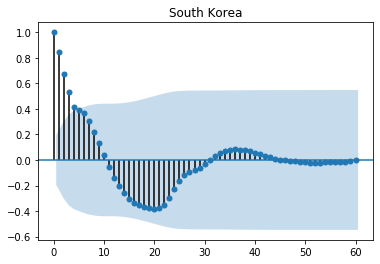

In [15]:
country = 'United States'       
auto_correlation_analyze(country)

country = 'Japan'       
auto_correlation_analyze(country)

country = 'Italy'       
auto_correlation_analyze(country)

country = 'South Korea'
auto_correlation_analyze(country)

Test MSE: 0.002283


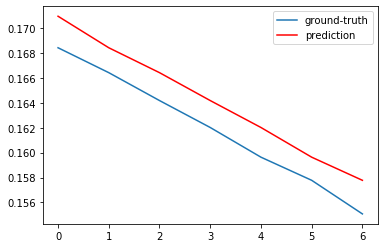

In [16]:
# predict using a baseline model which simply return the value of the previous day

from math import sqrt
from sklearn.metrics import mean_squared_error

# persistence model
def persistence_model(x):
    return x

def predict_persistent_model(country):
    res_by_country = search_by_country(country, loaded)
    sorted_samples = sort_by_date(res_by_country)

    dates = [key[0].strftime('%Y-%m-%d') for key in sorted_samples.keys()]

    # cumulative confirmed cases and tested cases
    cum_confirmed = [value.confirmed.cumulative for value in sorted_samples.values()]
    cum_tested = [value.tested.cumulative for value in sorted_samples.values()]

    confirmed_over_tested = [c / t for c, t in zip(cum_confirmed, cum_tested)]
    
    # combine into a DataFrame
    df = pd.DataFrame({'Date': dates, 'Ratio': confirmed_over_tested}).set_index('Date')
    
    # create lagged dataset
    values = pd.DataFrame(df.values)
    dataframe = pd.concat([values.shift(1), values], axis=1)
    dataframe.columns = ['t-1', 't+1']

    # split into train and test sets
    X = dataframe.values
    train, test = X[1:len(X)-7], X[len(X)-7:]
    train_X, train_y = train[:,0], train[:,1]
    test_X, test_y = test[:,0], test[:,1]

    # walk-forward validation
    predictions = list()
    for x in test_X:
        yhat = persistence_model(x)
        predictions.append(yhat)

    rmse = sqrt(mean_squared_error(test_y, predictions))
    print('Test MSE: %.6f' % rmse)
    
    # plot predictions vs expected
    plt.plot(test_y, label='ground-truth')
    plt.plot(predictions, color='red', label='prediction')
    
    plt.legend()
    plt.show()
    
country = 'United States'       
predict_persistent_model(country)

In [82]:
from datetime import datetime, timedelta
from statsmodels.tsa.ar_model import AutoReg

def predict_autoregression_model(country, hyperparam):
    res_by_country = search_by_country(country, loaded)
    sorted_samples = sort_by_date(res_by_country)

    dates = [key[0].strftime('%Y-%m-%d') for key in sorted_samples.keys()]

    # cumulative confirmed cases and tested cases
    cum_confirmed = [value.confirmed.cumulative for value in sorted_samples.values()]
    cum_tested = [value.tested.cumulative for value in sorted_samples.values()]

    confirmed_over_tested = [c / t for c, t in zip(cum_confirmed, cum_tested)]
    
    # combine into a DataFrame
    df = pd.DataFrame({'Date': dates, 'Ratio': confirmed_over_tested}).set_index('Date')
    
    # split dataset
    X = df.values
    train, test = X[1:len(X)-7], X[len(X)-7:]
    
    # train autoregression
    model = AutoReg(train, lags=hyperparam)
    model_fit = model.fit()
    print('Coefficients: %s' % model_fit.params)
    
    # make predictions
    predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

    for i in range(len(predictions)):
        print('predicted=%f, expected=%f' % (predictions[i], test[i]))

    rmse = sqrt(mean_squared_error(test, predictions))
    print('Val RMSE: %.6f' % rmse)

    # plot predictions vs expected
    plt.plot(test, label='ground-truth')
    plt.plot(predictions, color='red', label='prediction')
    plt.xlabel('date index')
    plt.ylabel('ratio')
    
    plt.legend()
    plt.title(country + ': val RMSE: %.6f' % rmse)
    
    # forecast for future days
    forecasts = model_fit.predict(start=len(train) + len(test), end=len(train) + len(test) + 6)
    for i in range(len(forecasts)):
        print('forecasted=%f' % (forecasts[i]))
    
    future_dates = []
    for i in range(len(forecasts)):
        fd = (datetime.strptime(dates[-1], '%Y-%m-%d') + timedelta(days=1 + i)).strftime('%Y-%m-%d')
        future_dates.append(fd)
    future_dates = datestr2num(future_dates)

    # plot forecast values
    rule = rrulewrapper(DAILY, interval=1)
    loc = RRuleLocator(rule)
    formatter = DateFormatter('%Y-%m-%d')
    
    fig, ax1 = plt.subplots()
    ax1.plot_date(future_dates, forecasts, 'r')
    ax1.set_ylabel('ratio', color='red')

    ax1.xaxis.set_major_locator(loc)
    ax1.xaxis.set_major_formatter(formatter)
    ax1.xaxis.set_tick_params(rotation=30, labelsize=10)
    
    plt.title(country)
    plt.show()

Coefficients: [0.0083051  0.88173096 0.07623938]
predicted=0.172193, expected=0.168421
predicted=0.173166, expected=0.166422
predicted=0.174119, expected=0.164183
predicted=0.175033, expected=0.162020
predicted=0.175912, expected=0.159637
predicted=0.176757, expected=0.157780
predicted=0.177569, expected=0.155082
Val RMSE: 0.014434
forecasted=0.178349
forecasted=0.179098
forecasted=0.179819
forecasted=0.180511
forecasted=0.181177
forecasted=0.181816
forecasted=0.182431


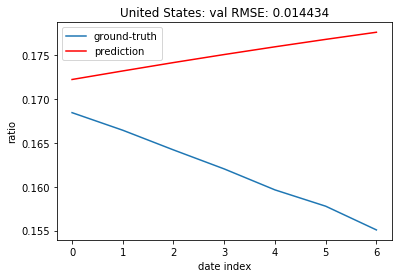

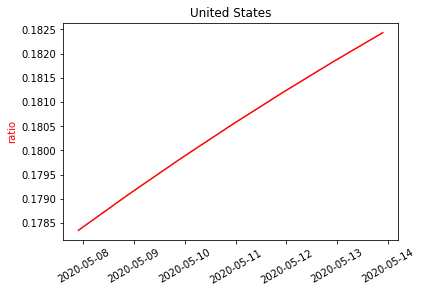

In [163]:
country = 'United States'       
predict_autoregression_model(country, hyperparam=20)

country = 'Japan'       
predict_autoregression_model(country, hyperparam=9)

country = 'Italy'       
predict_autoregression_model(country, hyperparam=20)

country = 'South Korea'       
predict_autoregression_model(country, hyperparam=40)

#### Autoregressive Moving Average Model

In [124]:
from statsmodels.tsa.arima_model import ARMA

def predict_arma_model(country, hyperparam):
    res_by_country = search_by_country(country, loaded)
    sorted_samples = sort_by_date(res_by_country)

    dates = [key[0].strftime('%Y-%m-%d') for key in sorted_samples.keys()]

    # cumulative confirmed cases and tested cases
    cum_confirmed = [value.confirmed.cumulative for value in sorted_samples.values()]
    cum_tested = [value.tested.cumulative for value in sorted_samples.values()]

    confirmed_over_tested = [c / t for c, t in zip(cum_confirmed, cum_tested)]
    
    # combine into a DataFrame
    df = pd.DataFrame({'Date': dates, 'Ratio': confirmed_over_tested}).set_index('Date')
    
    # split dataset
    X = df.values
    train, test = X[1:len(X)-7], X[len(X)-7:]
    
    # fit model
    model = ARMA(train, order=hyperparam)
    model_fit = model.fit(disp=0)
    print(model_fit.summary())

#     # plot residual errors
#     residuals = pd.DataFrame(model_fit.resid)
#     residuals.plot()
#     plt.show()

#     residuals.plot(kind='kde')
#     plt.show()
#     print(residuals.describe())
    
    # make predictions
    predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

    for i in range(len(predictions)):
        print('predicted=%f, expected=%f' % (predictions[i], test[i]))

    rmse = sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.6f' % rmse)

    # plot predictions vs expected
    plt.plot(test, label='ground-truth')
    plt.plot(predictions, color='red', label='prediction')
    plt.xlabel('date index')
    plt.ylabel('ratio')
    
    plt.legend()
    plt.title(country + ': val RMSE: %.6f' % rmse)
    
    # forecast for future days
    forecasts, stderr, conf_int = model_fit.forecast(steps=7)
    for i in range(len(forecasts)):
        print('forecasted=%f' % (forecasts[i]))
    
    future_dates = []
    for i in range(len(forecasts)):
        fd = (datetime.strptime(dates[-1], '%Y-%m-%d') + timedelta(days=1 + i)).strftime('%Y-%m-%d')
        future_dates.append(fd)
    future_dates = datestr2num(future_dates)

    # plot forecast values
    rule = rrulewrapper(DAILY, interval=1)
    loc = RRuleLocator(rule)
    formatter = DateFormatter('%Y-%m-%d')
    
    fig, ax1 = plt.subplots()
    ax1.plot_date(future_dates, forecasts, 'r')
    ax1.set_ylabel('ratio', color='red')

    ax1.xaxis.set_major_locator(loc)
    ax1.xaxis.set_major_formatter(formatter)
    ax1.xaxis.set_tick_params(rotation=30, labelsize=10)
    
    plt.title(country)
    plt.show()

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   54
Model:                    ARMA(10, 1)   Log Likelihood                 201.465
Method:                       css-mle   S.D. of innovations              0.005
Date:                Sun, 10 May 2020   AIC                           -376.929
Time:                        12:30:14   BIC                           -351.072
Sample:                             0   HQIC                          -366.957
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1603      0.011     15.016      0.000       0.139       0.181
ar.L1.y        0.9760      0.242      4.037      0.000       0.502       1.450
ar.L2.y        0.1631      0.252      0.646      0.5

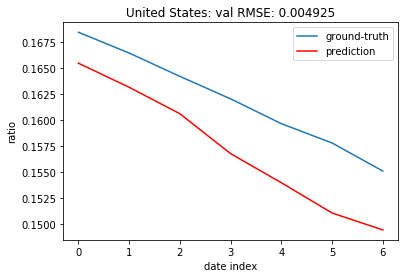

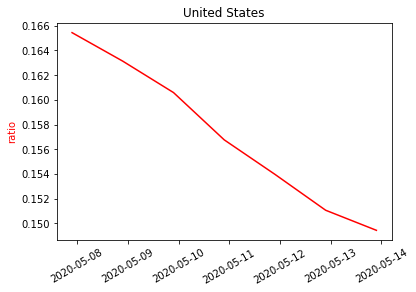

/home/aaron/miniconda3/envs/light/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   71
Model:                    ARMA(20, 1)   Log Likelihood                 344.630
Method:                       css-mle   S.D. of innovations              0.002
Date:                Sun, 10 May 2020   AIC                           -643.261
Time:                        12:38:00   BIC                           -591.219
Sample:                             0   HQIC                          -622.566
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0371      0.002     15.405      0.000       0.032       0.042
ar.L1.y        2.2752      0.084     26.939      0.000       2.110       2.441
ar.L2.y       -1.8005      0.194     -9.272      0.0

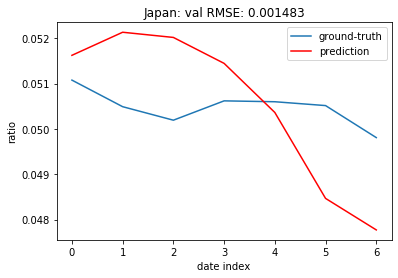

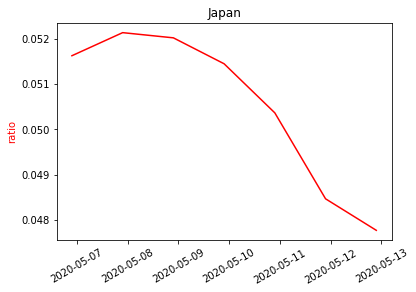

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   66
Model:                     ARMA(5, 1)   Log Likelihood                 235.656
Method:                       css-mle   S.D. of innovations              0.006
Date:                Sun, 10 May 2020   AIC                           -455.313
Time:                        12:38:31   BIC                           -437.796
Sample:                             0   HQIC                          -448.391
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1453      0.009     15.497      0.000       0.127       0.164
ar.L1.y        1.7835      0.123     14.484      0.000       1.542       2.025
ar.L2.y       -0.6317      0.246     -2.564      0.0

/home/aaron/miniconda3/envs/light/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/aaron/miniconda3/envs/light/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/home/aaron/miniconda3/envs/light/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/aaron/miniconda3/envs/light/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/aaron/miniconda3/envs/light/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


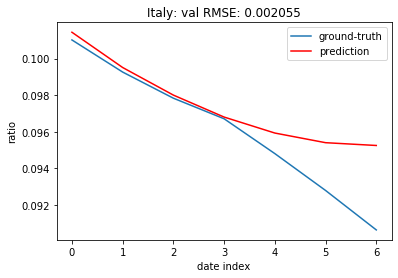

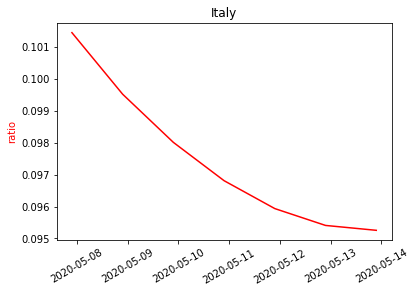

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   42
Model:                    ARMA(20, 1)   Log Likelihood                 166.907
Method:                       css-mle   S.D. of innovations              0.004
Date:                Sun, 10 May 2020   AIC                           -287.814
Time:                        12:46:01   BIC                           -247.847
Sample:                             0   HQIC                          -273.164
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1089      0.024      4.465      0.000       0.061       0.157
ar.L1.y        0.7910      0.168      4.697      0.000       0.461       1.121
ar.L2.y        0.7645      0.232      3.300      0.0

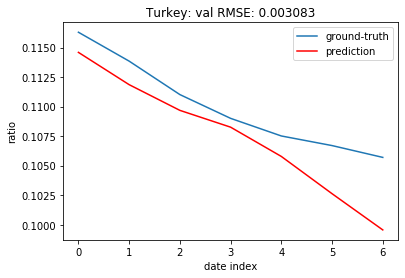

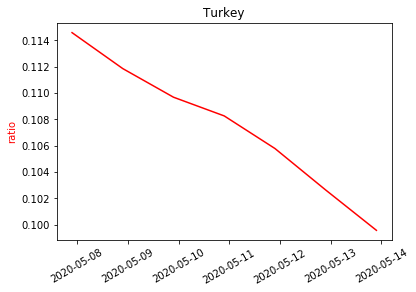

In [162]:
country = 'United States'       
predict_arma_model(country, hyperparam=(10, 1))

country = 'Japan'       
predict_arma_model(country, hyperparam=(20, 1))

country = 'Italy'       
predict_arma_model(country, hyperparam=(5, 1))

country = 'Turkey'       
predict_arma_model(country, hyperparam=(20, 1))

#### Vector Autoregression (VAR) model

In [186]:
from statsmodels.tsa.vector_ar.var_model import VAR

def predict_var_model(country, measurement, hyperparam):
    res_by_country = search_by_country(country, loaded)
    sorted_samples = sort_by_date(res_by_country)

    dates = [key[0].strftime('%Y-%m-%d') for key in sorted_samples.keys()]

    # cumulative confirmed cases and tested cases
    cum_confirmed = [value.confirmed.cumulative for value in sorted_samples.values()]
    cum_tested = [value.tested.cumulative for value in sorted_samples.values()]

    confirmed_over_tested = [c / t for c, t in zip(cum_confirmed, cum_tested)]
    
    if measurement == 'stringency':
        meas_values = [value.measure.stringency for value in sorted_samples.values()]
    else:
        meas_values = [getattr(value.measure, measurement) for value in sorted_samples.values()]
        
    # combine into a DataFrame
    df = pd.DataFrame({'Date': dates, 'Ratio': confirmed_over_tested, 'Measurement': meas_values}).set_index('Date')
    
    # split dataset
    X = df.values
    train, test = X[1:len(X)-7], X[len(X)-7:]
    
    model = VAR(train)
    model_fit = model.fit(hyperparam)
    
    # make predictions
    predictions = model_fit.forecast(train, steps=7)

    for i in range(len(predictions)):
        print('predicted=%f, expected=%f' % (predictions[i][0], test[i][0]))
  
    rmse = sqrt(mean_squared_error(test[:, 0], predictions[:, 0]))
    print('Test RMSE: %.6f' % rmse)

    # plot predictions vs expected
    plt.plot(test[:, 0], label='ground-truth')
    plt.plot(predictions[:, 0], color='red', label='prediction')
    plt.xlabel('date index')
    plt.ylabel('ratio')
    
    plt.legend()
    plt.title(country + ': val RMSE: %.6f' % rmse)
    plt.show()

#     forecasts = model_fit.forecast(X, steps=7)
#     for i in range(len(forecasts)):
#         print('forecasted=%f' % (forecasts[i][0]))
        
     # forecast for future days
    forecasts = model_fit.forecast(X, steps=7)
    for i in range(len(forecasts)):
        print('forecasted=%f' % (forecasts[i][0]))
    
    future_dates = []
    for i in range(len(forecasts)):
        fd = (datetime.strptime(dates[-1], '%Y-%m-%d') + timedelta(days=1 + i)).strftime('%Y-%m-%d')
        future_dates.append(fd)
    future_dates = datestr2num(future_dates)

    # plot forecast values
    rule = rrulewrapper(DAILY, interval=1)
    loc = RRuleLocator(rule)
    formatter = DateFormatter('%Y-%m-%d')
    
    fig, ax1 = plt.subplots()
    ax1.plot_date(future_dates, forecasts[:, 0], 'r')
    ax1.set_ylabel('ratio', color='red')

    ax1.xaxis.set_major_locator(loc)
    ax1.xaxis.set_major_formatter(formatter)
    ax1.xaxis.set_tick_params(rotation=30, labelsize=10)
    
    plt.title(country)
    plt.show()

predicted=0.172510, expected=0.168421
predicted=0.171355, expected=0.166422
predicted=0.166874, expected=0.164183
predicted=0.165255, expected=0.162020
predicted=0.163352, expected=0.159637
predicted=0.161656, expected=0.157780
predicted=0.160532, expected=0.155082
Test RMSE: 0.004093


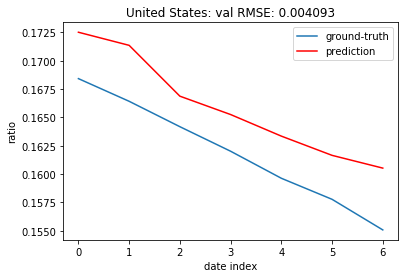

forecasted=0.160823
forecasted=0.160658
forecasted=0.157629
forecasted=0.157777
forecasted=0.157099
forecasted=0.155044
forecasted=0.151690


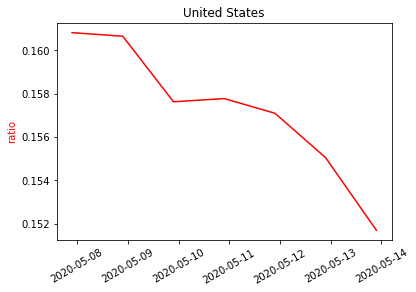

predicted=0.051552, expected=0.051077
predicted=0.052042, expected=0.050490
predicted=0.051231, expected=0.050193
predicted=0.051328, expected=0.050619
predicted=0.050020, expected=0.050600
predicted=0.048510, expected=0.050515
predicted=0.047404, expected=0.049809
Test RMSE: 0.001432


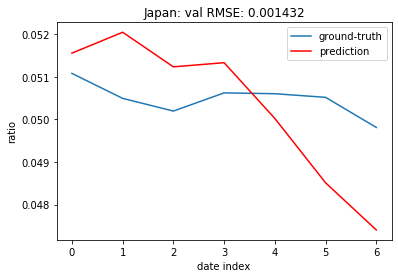

forecasted=0.048736
forecasted=0.047940
forecasted=0.047677
forecasted=0.047439
forecasted=0.046906
forecasted=0.046193
forecasted=0.045170


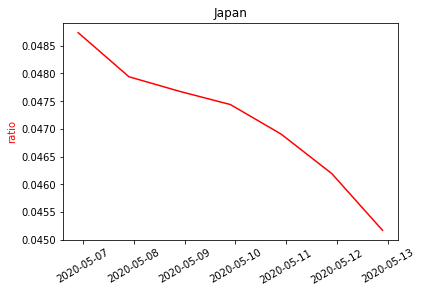

predicted=0.102128, expected=0.101016
predicted=0.100243, expected=0.099262
predicted=0.098907, expected=0.097836
predicted=0.096699, expected=0.096713
predicted=0.095005, expected=0.094813
predicted=0.093338, expected=0.092801
predicted=0.091950, expected=0.090648
Test RMSE: 0.000876


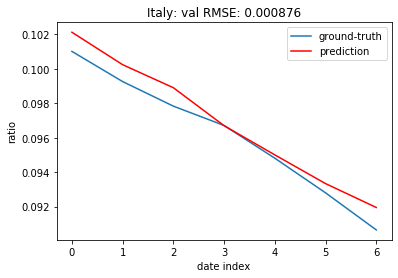

forecasted=0.089224
forecasted=0.087762
forecasted=0.086870
forecasted=0.085123
forecasted=0.083675
forecasted=0.082357
forecasted=0.081309


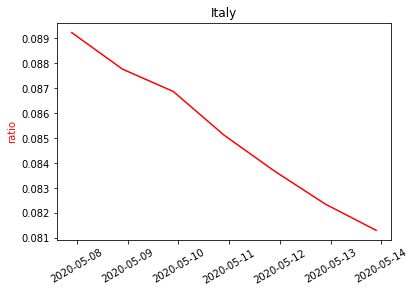

predicted=0.115609, expected=0.116295
predicted=0.112832, expected=0.113848
predicted=0.110516, expected=0.111017
predicted=0.108449, expected=0.109004
predicted=0.106183, expected=0.107513
predicted=0.104020, expected=0.106699
predicted=0.102005, expected=0.105698
Test RMSE: 0.001876


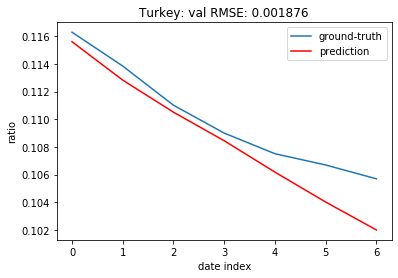

forecasted=0.102884
forecasted=0.098871
forecasted=0.094544
forecasted=0.091048
forecasted=0.087714
forecasted=0.084350
forecasted=0.081078


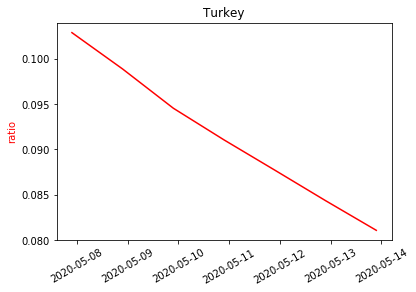

In [187]:
country = 'United States' 
measurement = 'stringency'
predict_var_model(country, measurement, 13)

country = 'Japan' 
measurement = 'stringency'
predict_var_model(country, measurement, 10)

country = 'Italy' 
measurement = 'stringency'
predict_var_model(country, measurement, 5)

country = 'Turkey' 
measurement = 'stringency'
predict_var_model(country, measurement, 5)